In [ ]:
# https://medium.com/digital-mind/visualizing-dinov2-contrastive-learning-and-classification-examples-9e6d8f87acf6
# https://jvgd.medium.com/dinov2-visualization-4a9df1a42387
#https://arxiv.org/pdf/2104.14294
#https://github.com/facebookresearch/dino/blob/main/main_dino.py
#https://paperswithcode.com/method/dino

In [47]:
import torch
from einops import rearrange
from torchvision.transforms import Normalize
from torchvision.transforms.functional import resize
from torchvision.utils import save_image
from torchvision.io.image import read_image, ImageReadMode

# Reading images and making sure they have same shape
I1 = read_image("images/image_1.jpeg", ImageReadMode.RGB)
I2 = read_image("images/image_2.jpg", ImageReadMode.RGB)

H, W = 672, 672
I1 = resize(I1, (H, W))
I2 = resize(I2, (H, W))

In [ ]:
I = torch.stack([I1, I2], dim=0)

In [ ]:
# Mean & Std for tensors normalized to [0, 1]
IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)

norm = Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)

I_norm = norm(I / 255)

In [48]:
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
dinov2.cuda()
I_norm = I_norm.cuda()
with torch.autocast(device_type='cuda'):
    features = dinov2.forward_features(I_norm)
    E_patch = features["x_norm_patchtokens"]

Using cache found in /gpfs/home/nk4167/.cache/torch/hub/facebookresearch_dinov2_main


In [49]:
E_patch_norm = rearrange(E_patch, "B L E -> (B L) E")

In [50]:
E_patch_norm.shape

torch.Size([4608, 768])

In [51]:
# Getting Values of the pricipal value decomposition
_, _, V = torch.pca_lowrank(E_patch_norm)

# Projecting embeddings to the first component of the V matrix
E_pca_1 = torch.matmul(E_patch_norm, V[:, :1])

In [52]:
def minmax_norm(x):
    """Min-max normalization"""
    return (x - x.min(0).values) / (x.max(0).values - x.min(0).values)
    
E_pca_1_norm = minmax_norm(E_pca_1)

In [53]:
M_fg = E_pca_1_norm.squeeze() > 0.5
M_bg = E_pca_1_norm.squeeze() <= 0.5 

In [54]:
# Getting Values of the pricipal value decomposition for foreground pixels
_, _, V = torch.pca_lowrank(E_patch_norm[M_fg])

# Projecting foreground embeddings to the first 3 component of the V matrix
E_pca_3_fg = torch.matmul(E_patch_norm[M_fg], V[:, :3])
E_pca_3_fg = minmax_norm(E_pca_3_fg)

In [55]:
B, L, _ = E_patch.shape
Z = B * L
I_draw = torch.zeros(Z,3)

In [57]:
E_pca_3_fg = E_pca_3_fg.cpu()

In [58]:
I_draw[M_fg] = E_pca_3_fg

In [59]:
I_draw = rearrange(I_draw, "(B L) C -> B L C", B=B)

In [60]:
I_draw.shape

torch.Size([2, 2304, 3])

In [61]:
I_draw = rearrange(I_draw, "B (h w) C -> B h w C", h=H//14, w=W//14)

In [62]:
# Unpacking PCA images
image_1_pca = I_draw[0]
image_2_pca = I_draw[1]

# To chanel first format torchvision format
image_1_pca = rearrange(image_1_pca, "H W C -> C H W")
image_2_pca = rearrange(image_2_pca, "H W C -> C H W")

# Resizing it to ease visualization 
image_1_pca = resize(image_1_pca, (H,W))
image_2_pca = resize(image_2_pca, (H,W))


In [69]:
import matplotlib.pyplot as plt
import numpy as np

In [72]:
image_1_pca.shape

torch.Size([3, 672, 672])

In [76]:
image_1_pca_plot = np.rollaxis(image_1_pca.detach().numpy(),0,3)

In [90]:
image_2_pca_plot = np.rollaxis(image_2_pca.detach().numpy(),0,3)

In [83]:
I1_plot = np.rollaxis(I1.detach().cpu().numpy(), 0,3)

In [86]:
I2_plot = np.rollaxis(I2.detach().cpu().numpy(), 0,3)

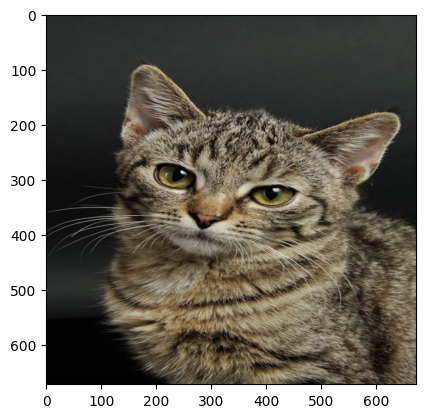

In [87]:
plt.imshow(I1_plot)

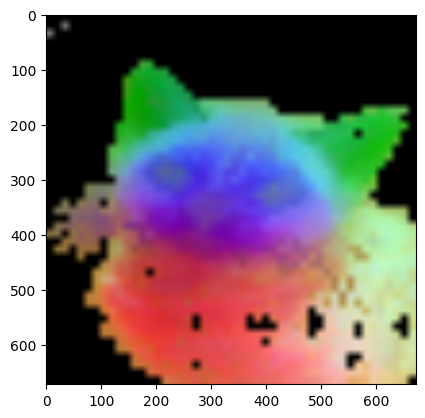

In [77]:
plt.imshow(image_1_pca_plot)

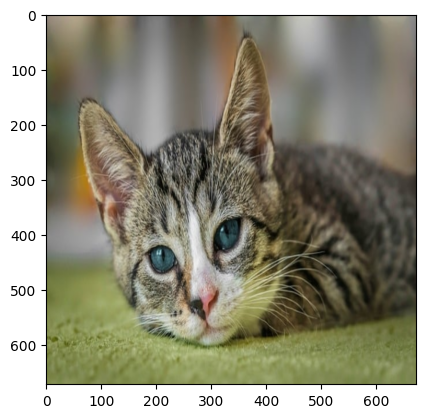

In [88]:
plt.imshow(I2_plot)

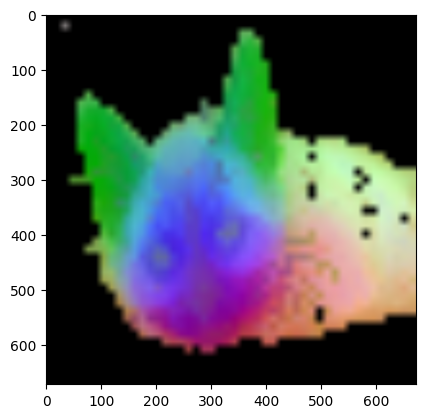

In [91]:
plt.imshow(image_2_pca_plot)